In [4]:
# import all modules required
import numpy as np              # for the arrays  
import matplotlib.pyplot as plt # for the plotting
import scipy.integrate as si    # to integrate numerically the equations of motion
import scipy.optimize as so     # for the bisection algorithm
import pandas as pd
# change to qt for plots in a new window
%matplotlib qt

ImportError: Failed to import any qt binding

### Parameters (spring)

In [5]:
# mass of squash ball
m = 0.025 # kg

# diameter of squash ball
d =  0.040 # mm

# mass of carrier
mc = 0.025 # kg

# mass of ball + carrier
mt = m + mc

# Number of springs in series
Ns = 1

# Number of springs in parallel
Np = 1

# Length of spring
L0 = 0.1016 * Ns # m
# Spring constant
k = 794/Ns*Np # N/m
# maximumum compression distance = 0.082 m

# Launch angle
theta = 67/180*np.pi # rad
count=1

# Gravitational acceleration
g = 9.81 # m/s^2

# Friction factor
f = 0.5 # N/(m/s)

# Spring position
xs = 0.2 # m
ys = 0.1 # m

### Parameters (Trajectory)

In [6]:
# density and dynamic viscosity of air
rho = 1.204    # kg/m^3
mu  = 1.825e-5 # Pa s 

### Initial Conditions for spring

In [7]:
# Initial spring compression
s0 = 0.02 # m

# Initial velocity
v0 = 0.0 # m/s

y0 = [s0, v0]

### Spring equation

In [8]:
# Spring equation
def spring(y, t):
    # unpack
    s, v = y
    # dsdt
    dsdt = -v
    # dvdt
    dvdt = k*s/mt - g*np.sin(theta) - f*v/mt
    
    return dsdt, dvdt

### Find maximum launching velocity

In [9]:
def maxVelocity(t_end):
    t = np.linspace(0, t_end, 100)
    sol = si.odeint(spring, y0, t)
    v, a = spring(sol[-1], t_end)
    return a

[5.268782971501959, 7.047521268926012, 8.82625957473183]


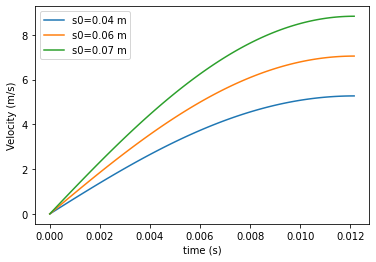

In [10]:
plt.clf()
y = []
for s0 in np.array([0.045,0.060,0.075])*Ns:
    y0 = [s0, v0]

    t_end = so.newton(maxVelocity, 0.013)

    t = np.linspace(0,t_end,100)

    sol = si.odeint(spring, y0, t)

    s = sol[:,0]
    v = sol[:,1]
    y.append(v[-1])
    plt.plot(t, v, label='s0=%0.2f m' % s0)
    
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('Velocity (m/s)')

print(y)

### Define functions/equations that needed for trajectory

In [11]:
# obtain drag coefficient from Reynolds number
def get_CD(Re):
    return 24/Re * (1 + 0.27*Re)**0.43 + 0.47 * (1 - np.exp(-0.04*Re**0.38))

In [12]:
# compute right hand side of governing equations at a generic
# position u, defining the x, y, Vx and Vy state variables
def squashball(u, t):
    # unpack u
    x, y, Vx, Vy = u
    
    # find theta
    theta = np.arctan2(Vy, Vx)
    
    # magnitude of velocity
    V_mag = np.sqrt(Vx**2 + Vy**2)
    
    # compute Reynolds number
    Re = rho * V_mag * d / mu
    
    # drag coefficient
    CD = get_CD(Re)
    
    # calculate drag (AND HERE IS WHERE THE MISTAKE WAS!!!)
    D_mag = 0.5 * rho * V_mag**2 * CD * d**2
    
    # calculate drag components
    Dx = D_mag * np.cos(theta)
    Dy = D_mag * np.sin(theta)
    
    # calculate acceleration
    ax = - Dx/m
    ay = - Dy/m - g
    
    # return velocity and acceleration
    return [Vx, Vy, ax, ay]

### Trajectory 

In [13]:
# return t, x, y, Vx, Vy given final integral time T
def trajectory(x0, y0, Vx0, Vy0, T=1):
    # pack IC into u0
    u0 = [x0, y0, Vx0, Vy0]
    
    # define array of times
    t  = np.linspace(0, T, 101)
    
    # integrate forward
    out = si.odeint(squashball, u0, t)

    # unpack data
    x  = out[:, 0]
    y  = out[:, 1]
    Vx = out[:, 2]
    Vy = out[:, 3]
    
    return t, x, y, Vx, Vy

### Trajectory with stop 

In [14]:
# return t, x, y, Vx, Vy from given IC with y[-1] = 0
def trajectory_with_stop(x0, y0, Vx0, Vy0):

    # return y at t=T from give initial conditions
    def find_y_at_T(T):
        t, x, y, Vx, Vy = trajectory(x0, y0, Vx0, Vy0, T=T)
        return y[-1]
    
    # find T_stop such that y(T_stop) = 0
    # find T_stop such that find_y_at_T(T_stop) = 0
    T_stop = so.newton(find_y_at_T, 2)
    
    return trajectory(x0, y0, Vx0, Vy0, T=T_stop)

### Define functions for calculating distance

In [15]:
# compute velocity components from velocity magnitude and angle
def mag2comp(V_mag, theta):
    return V_mag * np.cos(theta), V_mag * np.sin(theta)

In [16]:
# return distance given initial velocity (at 45 degrees)
def distance(V_mag, theta):
    # find velocity components
    Vx, Vy = mag2comp(V_mag, np.deg2rad(theta))

    # solve forward
    t, x, y, Vx, Vy = trajectory_with_stop(0, 0, Vx, Vy)
    
    # return final distance
    return x[-1]

Run 1 of 3
Run 2 of 3
Run 3 of 3


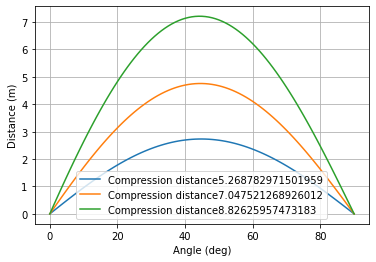

In [18]:
# initial velocities
V_mags = y
angle = np.linspace(0, 90, 91)
plt.clf()
count=1

xtotal=[]
for v in V_mags:
    print ('Run', count, 'of', len(V_mags))
    x=[]
    for theta in angle:
        c = distance(v, theta)
        x.append(c)
    xtotal.append(x)
    plt.plot(angle, x, label='Compression distance'+str(v))
    count+=1
plt.grid(1)
plt.legend(loc='best')
plt.xlabel('Angle (deg)')
plt.ylabel('Distance (m)')
plt.show()

### Output angle and compression based on required distance

In [25]:
input_distance=4 #INPUT TARGET DISTANCE HERE

def expected_distance(theta,v):
    y=distance(v,theta)
    return y-input_distance

sol=[]
for v_1 in V_mags:
    try:
        out_data=so.newton(expected_distance,30,args=(v_1,))
        out_txt='Compression of '+str(round(v_1,2))+'cm @ '+str(round(out_data,2))+' deg'
        sol.append(out_txt)
    except:
        err_txt='compression of '+str(round(v_1,2))+': failed to reach distance'
        sol.append(err_txt)

print (sol)

['compression of 5.27: failed to reach distance', 'Compression of 7.05cm @ 27.96 deg', 'Compression of 8.83cm @ 15.92 deg']


### Save datapoints as CSV

In [28]:
for i in range(len(xtotal)):
    xtotal[i]=[round(num,2) for num in xtotal[i]]
output_dict={'Angle':angle,'45mm':xtotal[0],'60mm':xtotal[1],'75mm':xtotal[2]}
output_dict=pd.DataFrame.from_dict(output_dict)
output_dict.to_csv()

',Angle,45mm,60mm,75mm\n0,0.0,0.0,0.0,0.0\n1,1.0,0.1,0.18,0.28\n2,2.0,0.2,0.35,0.55\n3,3.0,0.29,0.53,0.82\n4,4.0,0.39,0.7,1.09\n5,5.0,0.49,0.87,1.36\n6,6.0,0.58,1.04,1.62\n7,7.0,0.68,1.21,1.88\n8,8.0,0.77,1.37,2.14\n9,9.0,0.87,1.54,2.39\n10,10.0,0.96,1.7,2.64\n11,11.0,1.05,1.86,2.88\n12,12.0,1.14,2.01,3.12\n13,13.0,1.22,2.17,3.35\n14,14.0,1.31,2.32,3.58\n15,15.0,1.39,2.46,3.8\n16,16.0,1.48,2.6,4.02\n17,17.0,1.56,2.74,4.23\n18,18.0,1.63,2.88,4.43\n19,19.0,1.71,3.01,4.63\n20,20.0,1.78,3.14,4.82\n21,21.0,1.85,3.26,5.01\n22,22.0,1.92,3.38,5.19\n23,23.0,1.99,3.5,5.36\n24,24.0,2.05,3.61,5.53\n25,25.0,2.12,3.71,5.69\n26,26.0,2.18,3.82,5.84\n27,27.0,2.23,3.91,5.98\n28,28.0,2.29,4.0,6.12\n29,29.0,2.34,4.09,6.24\n30,30.0,2.38,4.17,6.37\n31,31.0,2.43,4.25,6.48\n32,32.0,2.47,4.32,6.58\n33,33.0,2.51,4.39,6.68\n34,34.0,2.55,4.45,6.77\n35,35.0,2.58,4.5,6.85\n36,36.0,2.61,4.55,6.92\n37,37.0,2.64,4.6,6.99\n38,38.0,2.66,4.64,7.05\n39,39.0,2.68,4.67,7.09\n40,40.0,2.7,4.7,7.13\n41,41.0,2.71,4.72,7.17\n42,